In [1]:
import random
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras import optimizers,regularizers
import _pickle as cPickle

Using TensorFlow backend.


In [3]:
#### remove all the irrelavant variables, do a simplified simulation
np.random.seed(867)
N = 5000
x1 = np.random.normal(0, 1, N)
x2 = np.random.normal(0, 1, N)
x3 = np.random.normal(0, 1, N)
x4 = np.random.randint(1, 5, N)
d = {'x1': x1, 'x2': x2, 'x3': x3,'x4': x4}
df = pd.DataFrame(data=d)
df = pd.get_dummies(df, columns=["x4"])
x4_1 = df.iloc[:,3]
x4_2 = df.iloc[:,4]
x4_3 = df.iloc[:,5]
x4_4 = df.iloc[:,6]
df['inter1'] = pd.Series((x1*x2-np.mean(x1*x2))/np.std(x1*x2), index=df.index)
df['inter2'] = pd.Series((x4_1*x3-np.mean(x4_1*x3))/np.std(x4_1*x3), index=df.index)
df['inter3'] = pd.Series((x4_2*x3-np.mean(x4_2*x3))/np.std(x4_2*x3), index=df.index)
df['inter4'] = pd.Series((x4_3*x3-np.mean(x4_3*x3))/np.std(x4_3*x3), index=df.index)
df['inter5'] = pd.Series((x4_4*x3-np.mean(x4_4*x3))/np.std(x4_4*x3), index=df.index)
main_effect = [0.3,0.1,0.1,0.1,0.2,0.3,0.4]
main_matrix = np.column_stack((x1,x2**2,0.5*np.exp(x3),x4_1,x4_2,x4_3,x4_4))
inter_matrix = np.column_stack((x1*x2**2,0.5*np.exp(x3)*x4_1,0.5*np.exp(x3)*x4_2,0.5*np.exp(x3)*x4_3,0.5*np.exp(x3)*x4_4))
df.head()

,x1,x2,x3,x4_1,x4_2,x4_3,x4_4,inter1,inter2,inter3,inter4,inter5
0,-0.154005,0.197094,0.123579,0.0,0.0,0.0,1.0,-0.012515,0.008493,0.006318,0.039944,0.261018
1,-1.069379,1.314449,-2.132584,0.0,0.0,1.0,0.0,-1.369655,0.008493,0.006318,-4.231714,0.009344
2,0.161591,0.503896,1.493674,0.0,1.0,0.0,0.0,0.097788,0.008493,2.955005,0.039944,0.009344
3,0.029792,-0.061004,-0.568154,0.0,1.0,0.0,0.0,0.015644,0.008493,-1.115285,0.039944,0.009344
4,-1.079196,0.091550,-0.817524,1.0,0.0,0.0,0.0,-0.080059,-1.654195,0.006318,0.039944,0.009344


In [41]:
## zoom in 0-5, with regularization
max_epoch = 100
table = np.zeros((10,11,5))
for k in range(10):
    for i in range(11):
        t = 0.05*i
        inter_effect = np.array([1,0.5,1,2,3])*t
        eta_wo_intercept = np.dot(main_matrix,main_effect) + np.dot(inter_matrix,inter_effect)
        intercept = -np.mean(eta_wo_intercept)
        eps = np.random.normal(0, 1, N)
        eta = eta_wo_intercept + intercept + eps
        p = np.exp(eta)/(1+np.exp(eta))
        y = np.zeros(N)
        y[p>0.5]=1
        forest = ExtraTreesClassifier(n_estimators=20, random_state=0)
        forest.fit(df, y)
        importances = forest.feature_importances_
        std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
        inter_prop1 = 1-sum(importances[range(7)])
        x = np.array(df)
        y = np.array(y)
        m = LogisticRegression()
        m.fit(x, y)
        inter_prop2 = 1-sum((np.std(x, 0)*abs(m.coef_))[0][0:6])/sum((np.std(x, 0)*abs(m.coef_))[0])
        inter_prop = (inter_prop1+inter_prop2)/2
        model1 = Sequential()
        model1.add(Dense(20, input_dim=np.shape(x)[1],kernel_regularizer=regularizers.l2(0.02),activation='tanh'))
        model1.add(Dense(1, activation='sigmoid'))
        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        model1.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])
        trace1 = model1.fit(x[0:4000,:], y[0:4000],epochs=max_epoch,batch_size=64,verbose=0)
        score1 = model1.evaluate(x[4000:5000,:], y[4000:5000], batch_size=64)
        model2 = Sequential()
        num_main = 7
        model2.add(Dense(20, input_dim=num_main,kernel_regularizer=regularizers.l2(0.02),activation='tanh'))
        model2.add(Dense(1, activation='sigmoid'))
        model2.compile(loss='binary_crossentropy',optimizer=sgd, metrics=['accuracy'])
        trace2 = model2.fit(x[0:4000,0:num_main], y[0:4000],epochs=max_epoch,batch_size=64,verbose=0)
        score2 = model2.evaluate(x[4000:5000,0:num_main], y[4000:5000], batch_size=64)
        best_acc = np.transpose(trace2.history['acc'])[70]
        step2 = min(np.where(np.transpose(trace2.history['acc'])>=best_acc)[0])
        if len(np.where(np.transpose(trace1.history['acc'])>=best_acc)[0])==0:
            step1 = max_epoch
        else:
            step1 = min(np.where(np.transpose(trace1.history['acc'])>=best_acc)[0])
        table[k,i,:]=np.array([i,inter_prop,step2-step1,score1[1],score2[1]])

cPickle.dump(table, open("small_table.pkl2", "wb" ) )

1000/1000 [==============================] - 9s     


In [42]:
table2 = cPickle.load( open( "small_table.pkl2", "rb" ))
final_table2 = np.zeros((11,5))
for i in range(10):
    final_table2 = final_table2 + table2[i,:,:]
final_table2 = final_table2/10
steps2 = np.zeros(11)
for i in range(11):
    steps2[i] = np.mean(np.sort(table2[:,i,2])[2:7])

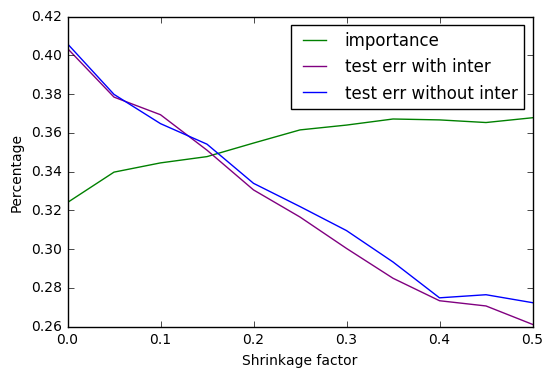

In [46]:
plt.plot(final_table2[:,0]*0.05,final_table2[:,1],color='green',label='importance')
plt.plot(final_table2[:,0]*0.05,1-final_table2[:,3],color="purple",label='test err with inter')
plt.plot(final_table2[:,0]*0.05,1-final_table2[:,4],color="blue",label='test err without inter')
plt.xlim((0,0.5))
plt.xlabel('Shrinkage factor')
plt.ylabel('Percentage')
plt.legend(loc=1)
plt.show()

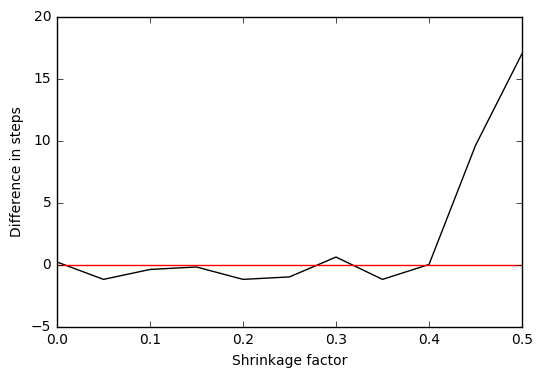

In [47]:
plt.plot(final_table2[:,0]*0.05,steps2,color="black")
plt.plot(final_table2[:,0]*0.05,final_table2[:,2]*0,color="red")
plt.xlabel('Shrinkage factor')
plt.ylabel('Difference in steps')
plt.show()